### First experiments with U-Net on FOCI sst data

Try U-Net following [Xiantao et al., 2020](https://www.nature.com/articles/s41598-020-59801-x), but with only 4 convolutions, opposed to 5. Work with slp fields from Earth System Models, here FOCI.

Choose **mask type**: Can either have random mask of missing values, individually for each data sample ('variable'), or create only a single random mask, that is then applied to all samples identically ('fixed'). 
And optionally extend data with **augmentation factor**: Specify the number of times, each sample is to be cloned, keeping the original order.

#### Experiments:

1) **mask_type='fixed', augmentation_factor=1:** Base experiment, according to szenario to have limitet number of measurements from stations, that are fixed in their location. Fast to train, low ressources required.

Use **sparse and scaled (to [0,1]) samples as inputs**. Use **complete and scaled (to [0,1]) samples as targets**.

Got results on nesh, using GPU cluster node with batch **unet_4conv_slp_FOCI_fixed_discrete_factor_1.py**. 

In [1]:
import os
import sys
sys.path.append('../reconstruct_missing_data')

from pathlib import Path
from json import dump, load

import numpy as np
from matplotlib import pyplot as plt

from data_loading import find_data_files, load_data_set, get_anomalies, clone_data, create_missing_mask, split_and_scale_data
from models import build_unet_4conv

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, concatenate, Conv1D, Conv2D, MaxPool2D, UpSampling2D, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow.keras.initializers as tfi
import tensorflow.keras.regularizers as tfr
from tensorflow.keras.utils import plot_model

# Suppress Tensorflow warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
# Set working directory, according to working directory in scripts:
os.chdir('/gxfs_work1/geomar/smomw511')

In [3]:
## Decide to work on test data or full data:
# path_to_data = 'GitHub/MarcoLandtHayen/reconstruct_missing_data/data/test_data/' # Test data
path_to_data = 'climate_index_collection/data/raw/2022-08-22/' # Full data

# Specify experiment:
model_config = 'unet_4conv'
feature = 'sea-surface-temperature' # Choose either 'sea-level-pressure' or 'sea-surface-temperature' as feature.
feature_short = 'sst' # Free to set short name, to store results, e.g. 'slp' and 'sst'.
source = 'FOCI' # Choose Earth System Model, either 'FOCI' or 'CESM'.
seed = 1 # Seed for random number generator, for reproducibility of missing value mask.
mask_type = 'variable'
missing_type = 'discrete'
augmentation_factor = 1

# Reconstruct path to experiment:
run = '_seed_1'
path = Path('GitGeomar/marco-landt-hayen/reconstruct_missing_data/results/'+model_config+'_'+feature_short+'_'+source+'_'+mask_type+'_'+missing_type+'_factor_'+str(augmentation_factor)+run)
# Reload parameters for this experiment:
with open(path / 'parameters.json', 'r') as f:
    parameters=load(f)

train_val_split = parameters['train_val_split']
missing_values = parameters['missing_values']
scale_to = parameters['scale_to']
epochs = parameters['epochs']

Rel. amount of missing values:  0.99
[0.16674301 0.00234089 0.00109119 0.00068239 0.00048436 0.00036192
 0.00391775 0.00174418 0.00125973 0.00090513 0.0007266 ]
[0.16817157 0.0023552  0.00110753 0.00069637 0.00050305 0.00037614
 0.00395454 0.00175648 0.00128528 0.00091738 0.00074106] 



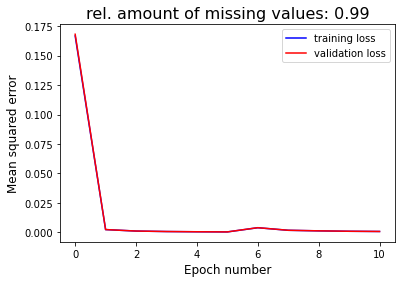

Rel. amount of missing values:  0.95
[0.16380905 0.00184864 0.00063578 0.00047607 0.00051707 0.00039021
 0.00033332 0.00027177 0.00024798 0.00024448 0.00022371]
[0.165211   0.00187044 0.0006342  0.00050303 0.00054745 0.00038744
 0.00035073 0.0002765  0.00025195 0.00024385 0.00023168] 



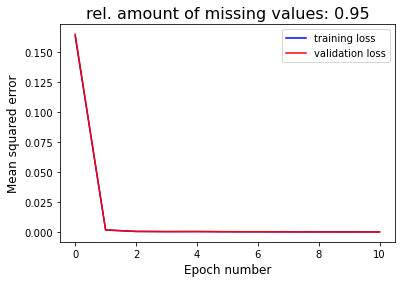

Rel. amount of missing values:  0.9
[0.16306395 0.00194195 0.00088673 0.00044646 0.00041265 0.00039979
 0.0004905  0.00037871 0.00035476 0.00037474 0.00032115]
[0.16445883 0.00195135 0.00094331 0.00045872 0.00042033 0.00040562
 0.00047351 0.00038269 0.0003649  0.00037888 0.00033583] 



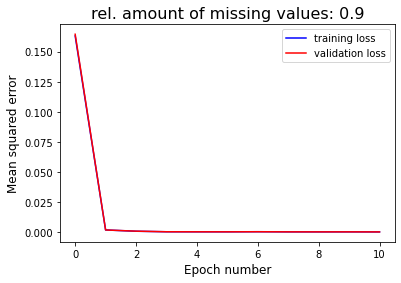

Rel. amount of missing values:  0.75
[1.66682141e-01 5.56485721e-04 2.20561067e-04 1.85703330e-04
 1.56760037e-04 1.70753416e-04 1.62653915e-04 1.60983331e-04
 1.34750314e-04 1.40561944e-04 1.07378732e-04]
[1.68109956e-01 5.59752127e-04 2.22022481e-04 1.87992531e-04
 1.58461937e-04 1.72115619e-04 1.63592736e-04 1.62191149e-04
 1.35865020e-04 1.41577667e-04 1.08243414e-04] 



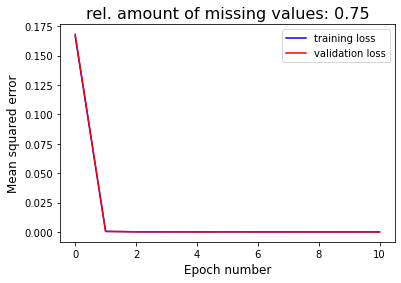

Rel. amount of missing values:  0.5
[1.62841370e-01 1.43726779e-04 1.15837684e-04 9.58181578e-05
 1.66769626e-01 1.66769620e-01 1.66769630e-01 1.66769620e-01
 1.66769621e-01 1.66769620e-01 1.66769620e-01]
[1.64235048e-01 1.45136089e-04 1.16702448e-04 9.65510343e-05
 1.68198485e-01 1.68198476e-01 1.68198482e-01 1.68198477e-01
 1.68198478e-01 1.68198476e-01 1.68198475e-01] 



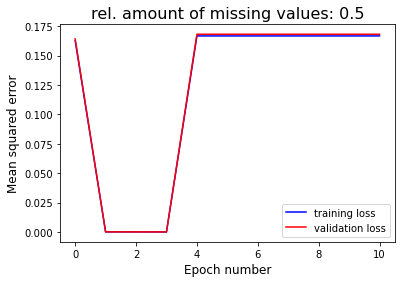

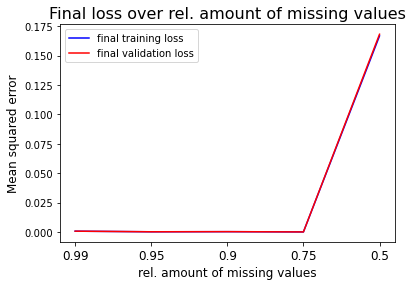

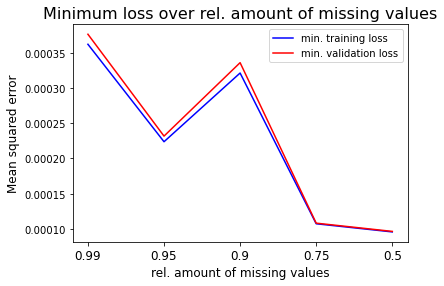

In [7]:
## Get an overview of train and validation loss, depending on sparsity.
## Note: Start with epoch 0, hence untrained model.

# Initialize storage for final and minimum train and validation loss:
train_loss_final = []
val_loss_final = []
train_loss_min = []
val_loss_min = []

# Loop over array of desired sparsity:
for i in range(len(missing_values)):
        
    # Get current relative amount of missing values:
    missing = missing_values[i]
    
    # Reload loss:
    train_loss = np.load(path / 'missing_' f'{int(missing*100)}'/ 'train_loss.npy')
    val_loss = np.load(path / 'missing_' f'{int(missing*100)}'/ 'val_loss.npy')
    
    print("Rel. amount of missing values: ", missing)
    print(train_loss)
    print(val_loss,"\n")
    
    # Plot train and val_loss (bin. cross-entropy)
    plt.plot(train_loss, color = 'blue', label = 'training loss')
    plt.plot(val_loss, color = 'red', label = 'validation loss')
    plt.xlabel('Epoch number', fontsize=12)
    plt.ylabel('Mean squared error', fontsize=12)
    #plt.ylim(0.6, 0.8)
    plt.title('rel. amount of missing values: '+str(missing), fontsize=16)
    plt.legend()
    plt.show() 
    
    # Store final and minimum train and validation loss:
    train_loss_final.append(train_loss[-1])
    val_loss_final.append(val_loss[-1])
    train_loss_min.append(np.min(train_loss))
    val_loss_min.append(np.min(val_loss))

# Plot final train and validation loss over sparsity:
plt.plot(train_loss_final, color = 'blue', label = 'final training loss')
plt.plot(val_loss_final, color = 'red', label = 'final validation loss')
plt.xlabel('rel. amount of missing values', fontsize=12)
plt.ylabel('Mean squared error', fontsize=12)
plt.xticks(np.arange(0, len(missing_values), step=1), missing_values, fontsize=12)
#plt.ylim(0.6, 0.8)
plt.title('Final loss over rel. amount of missing values', fontsize=16)
plt.legend()
plt.show() 

# Plot minimum train and validation loss over sparsity:
plt.plot(train_loss_min, color = 'blue', label = 'min. training loss')
plt.plot(val_loss_min, color = 'red', label = 'min. validation loss')
plt.xlabel('rel. amount of missing values', fontsize=12)
plt.ylabel('Mean squared error', fontsize=12)
plt.xticks(np.arange(0, len(missing_values), step=1), missing_values, fontsize=12)
#plt.ylim(0.6, 0.8)
plt.title('Minimum loss over rel. amount of missing values', fontsize=16)
plt.legend()
plt.show() 

In [77]:
# run = ''
print(np.round(train_loss_final,6))
print(np.round(val_loss_final,6))

[6.26000e-04 1.43000e-04 1.43000e-04 1.66782e-01 2.01000e-04]
[6.38000e-04 1.46000e-04 1.44000e-04 1.68211e-01 2.02000e-04]


### Inspect all models

In [78]:
## Compare predictions and targets, depending on rel. amount of missing values and training progress (epoch).
## Note: Start with epoch 0, hence untrained model.

# Specify number of samples to be considered (to minimize computational effort):
n_samples = 2

# Initialize storage for train and validation inputs: Dimensions (#missing value settings, #samples, lat, lon)
train_input_all = np.zeros((len(missing_values), n_samples, data.shape[1], data.shape[2]))
val_input_all = np.zeros((len(missing_values), n_samples, data.shape[1], data.shape[2]))

# Initialize storage for train and validation targets: Dimensions (#samples, lat, lon)
train_target_all = np.zeros((n_samples, data.shape[1], data.shape[2]))
val_target_all = np.zeros((n_samples, data.shape[1], data.shape[2]))

# Initialize storage for train and validation predictions: Dimensions (#missing value settings, #epochs + 1, #samples, lat, lon)
train_pred_all = np.zeros((len(missing_values), epochs+1, n_samples, data.shape[1], data.shape[2]))
val_pred_all = np.zeros((len(missing_values), epochs+1, n_samples, data.shape[1], data.shape[2]))

# Loop over array of desired sparsity:
for i in range(len(missing_values)):
        
    # Get current rel. amount of missing values:
    missing = missing_values[i]
    
    # Show status:
    print('missing values: ', i+1, ' of ', len(missing_values))
    
    ## Reconstruct sparse data and inputs and targets:

    # Load data, only to infer sample dimensions (lat,lon):
    data = load_data_set(data_path=path_to_data, data_source_name=source)

    # Select single feature and compute anomalies, using whole time span as climatology:
    data = get_anomalies(feature=feature, data_set=data)

    # Extend data, if desired:
    data = clone_data(data=data, augmentation_factor=augmentation_factor)

    # Reload mask for missing values:
    missing_mask = np.load(path / 'missing_' f'{int(missing*100)}' / 'missing_mask.npy')
    
    # Use sparse data as inputs and complete data as targets. Split sparse and complete data into training and validation sets. 
    # Scale or normlalize data according to statistics obtained from only training data.
    train_input, val_input, train_target, val_target, train_min, train_max, train_mean, train_std = split_and_scale_data(
        data, 
        missing_mask, 
        train_val_split, 
        scale_to
    )
    
    # Store inputs: Omit final dimension of predictions, that only contains the channel (here: 1)
    train_input_all[i,:,:,:] = train_input[:n_samples,:,:,0]
    val_input_all[i,:,:,:] = val_input[:n_samples,:,:,0]
    
    # Store targets, min and max values, and set former NaN values to NaN: Only once!
    if i == 0:
        train_target_all[:,:,:] = train_target[:n_samples,:,:]
        val_target_all[:,:,:] = val_target[:n_samples,:,:]
        
        train_target_min = np.min(train_target_all,axis=(1,2))
        train_target_max = np.max(train_target_all,axis=(1,2))
        val_target_min = np.min(val_target_all,axis=(1,2))
        val_target_max = np.max(val_target_all,axis=(1,2))
                
        train_target_all[train_target_all==0] = float('nan')
        val_target_all[val_target_all==0] = float('nan')       
        
    
    # Loop over number of epochs:
    for j in range(epochs+1):
        
        # Show status:
        print('  Epoch: ', j, ' of ', epochs)
        
        # Reload desired model:
        model = tf.keras.models.load_model(path / 'missing_' f'{int(missing*100)}' / f'epoch_{j}')
        
        # Get model predictions on train and validation data (only first 2 samples):
        train_pred = model.predict(train_input[:n_samples])
        val_pred = model.predict(val_input[:n_samples])
        
        # Set former NaN values to NaN, to highlight land masses.
        train_pred[train_pred==0] = float('nan')
        val_pred[val_pred==0] = float('nan') 
        
        # Store predictions: Omit final dimension of predictions, that only contains the channel (here: 1)
        train_pred_all[i,j,:,:,:] = train_pred[:,:,:,0]
        val_pred_all[i,j,:,:,:] = val_pred[:,:,:,0]

missing values:  1  of  5


/app/conda/lib/python3.8/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/app/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


  Epoch:  0  of  10
  Epoch:  1  of  10
  Epoch:  2  of  10
  Epoch:  3  of  10
  Epoch:  4  of  10
  Epoch:  5  of  10
  Epoch:  6  of  10
  Epoch:  7  of  10
  Epoch:  8  of  10
  Epoch:  9  of  10
  Epoch:  10  of  10
missing values:  2  of  5


/app/conda/lib/python3.8/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/app/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


  Epoch:  0  of  10
  Epoch:  1  of  10
  Epoch:  2  of  10
  Epoch:  3  of  10
  Epoch:  4  of  10
  Epoch:  5  of  10
  Epoch:  6  of  10
  Epoch:  7  of  10
  Epoch:  8  of  10
  Epoch:  9  of  10
  Epoch:  10  of  10
missing values:  3  of  5


/app/conda/lib/python3.8/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/app/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


  Epoch:  0  of  10
  Epoch:  1  of  10
  Epoch:  2  of  10
  Epoch:  3  of  10
  Epoch:  4  of  10
  Epoch:  5  of  10
  Epoch:  6  of  10
  Epoch:  7  of  10
  Epoch:  8  of  10
  Epoch:  9  of  10
  Epoch:  10  of  10
missing values:  4  of  5


/app/conda/lib/python3.8/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/app/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


  Epoch:  0  of  10
  Epoch:  1  of  10
  Epoch:  2  of  10
  Epoch:  3  of  10
  Epoch:  4  of  10
  Epoch:  5  of  10
  Epoch:  6  of  10
  Epoch:  7  of  10
  Epoch:  8  of  10
  Epoch:  9  of  10
  Epoch:  10  of  10
missing values:  5  of  5


/app/conda/lib/python3.8/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/app/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


  Epoch:  0  of  10
  Epoch:  1  of  10
  Epoch:  2  of  10
  Epoch:  3  of  10
  Epoch:  4  of  10
  Epoch:  5  of  10
  Epoch:  6  of  10
  Epoch:  7  of  10
  Epoch:  8  of  10
  Epoch:  9  of  10
  Epoch:  10  of  10


In [94]:
## Plot for single TRAINING input sample: Sparse input, target (=complete data) and predictions over the epochs (start with 0, hence untrained model),
## for specific rel. amount of missing values:

# Select rel. amount of missing values setting:
i=1

# Pick sample:
k=0

# Check:
print("rel. amount of missing values: ", missing_values[i])

rel. amount of missing values:  0.95


In [95]:
train_input.shape

(9600, 96, 192, 1)

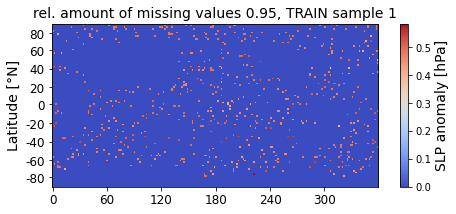

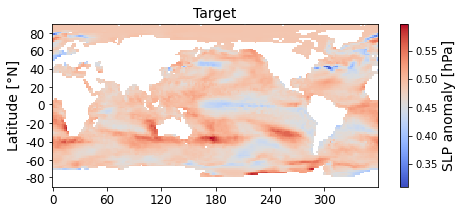

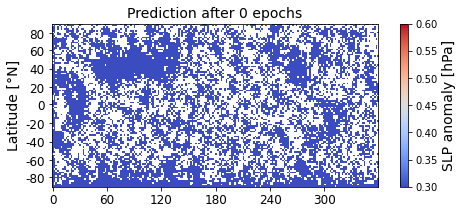

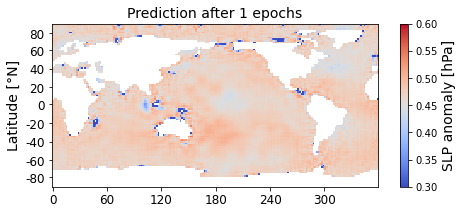

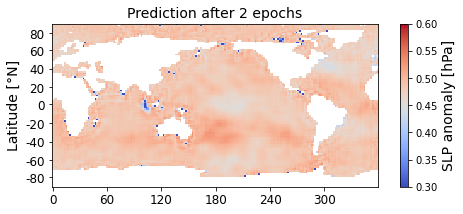

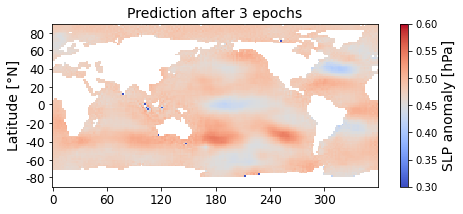

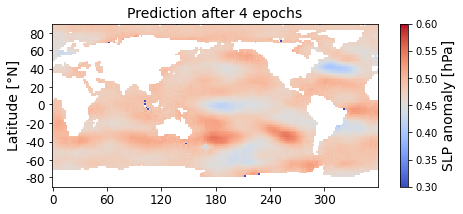

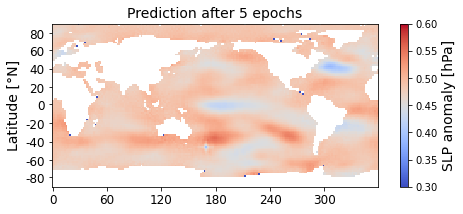

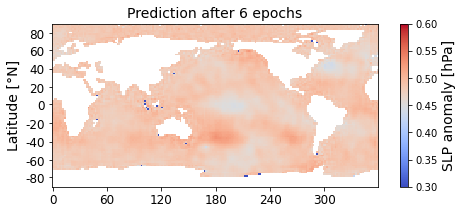

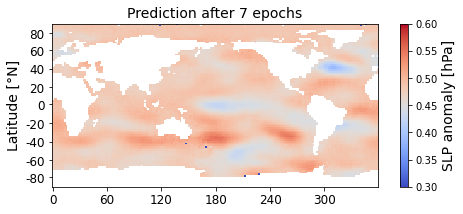

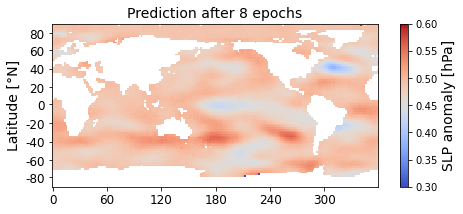

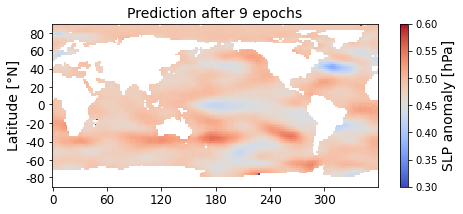

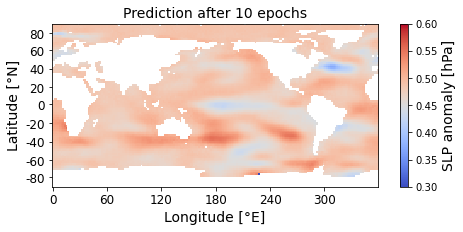

In [96]:
## Plot desired input sample from TRAINING data:
fig, ax = plt.subplots(figsize=(8, 3))

im = plt.imshow(train_input_all[i,k,:,:], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label("SLP anomaly [hPa]", fontsize=14)

plt.title('rel. amount of missing values '+str(missing_values[i])+', TRAIN sample '+str(k+1), fontsize=14)
#plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 192, step=32), [0, 60, 120, 180, 240, 300], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)

plt.show()

## Plot corresponding target:
fig, ax = plt.subplots(figsize=(8, 3))

im = plt.imshow(train_target_all[k], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label("SLP anomaly [hPa]", fontsize=14)

plt.title('Target', fontsize=14)
#plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 192, step=32), [0, 60, 120, 180, 240, 300], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)

plt.show()

## Plot corresponding model prediction:

# Loop over epochs:
for j in range(epochs+1):

    fig, ax = plt.subplots(figsize=(8, 3))

    im = plt.imshow(train_pred_all[i,j,k,:,:], cmap="coolwarm", interpolation='nearest', vmin=0.3, vmax=0.6)
    cbar = plt.colorbar(im)
    cbar.set_label("SLP anomaly [hPa]", fontsize=14)

    plt.title('Prediction after '+str(j)+' epochs', fontsize=14)
    if j == epochs:
        plt.xlabel('Longitude [°E]', fontsize=14)
    plt.ylabel('Latitude [°N]', fontsize=14)
    plt.xticks(np.arange(0, 192, step=32), [0, 60, 120, 180, 240, 300], fontsize=12)
    plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)

    plt.show()


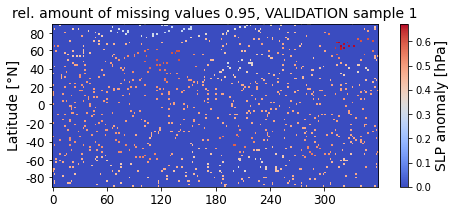

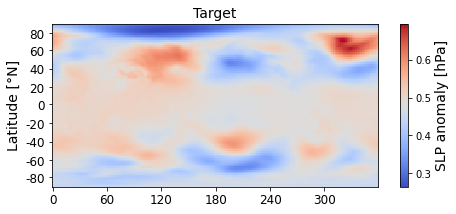

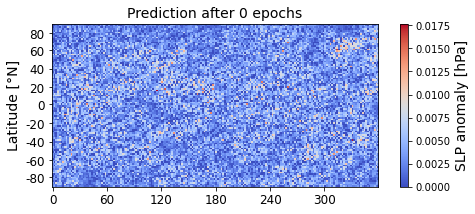

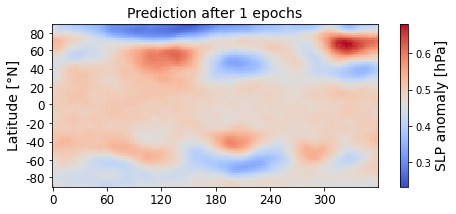

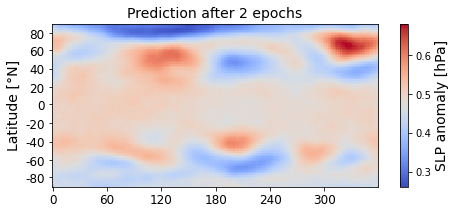

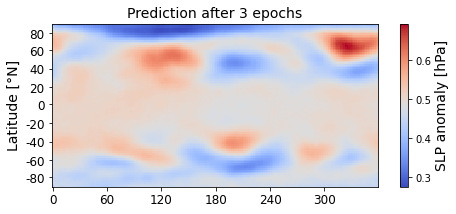

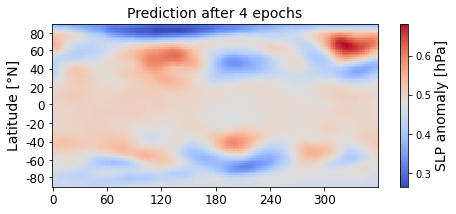

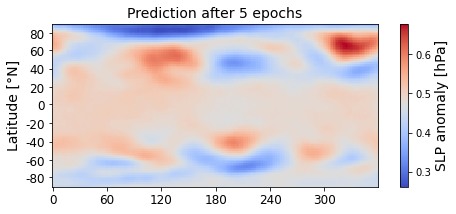

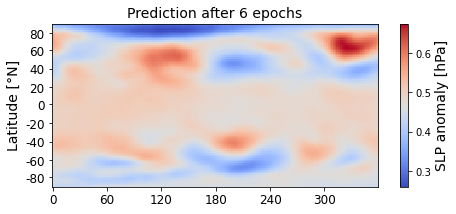

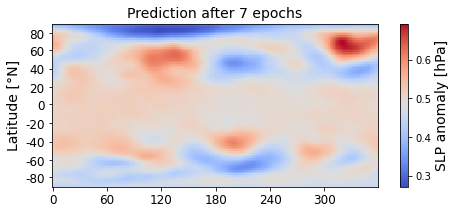

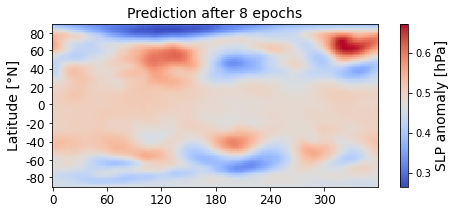

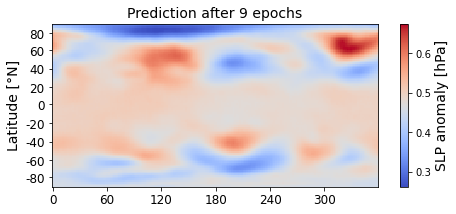

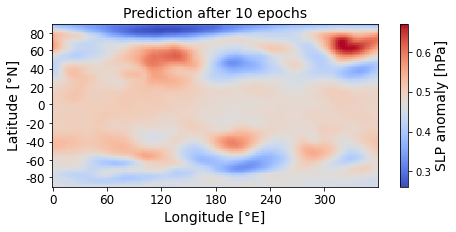

In [39]:
## Plot desired input sample from VALIDATION data:
fig, ax = plt.subplots(figsize=(8, 3))

im = plt.imshow(val_input_all[i,k,:,:], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label("SLP anomaly [hPa]", fontsize=14)

plt.title('rel. amount of missing values '+str(missing_values[i])+', VALIDATION sample '+str(k+1), fontsize=14)
#plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 192, step=32), [0, 60, 120, 180, 240, 300], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)

plt.show()

## Plot corresponding target:
fig, ax = plt.subplots(figsize=(8, 3))

im = plt.imshow(val_target_all[k], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label("SLP anomaly [hPa]", fontsize=14)

plt.title('Target', fontsize=14)
#plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 192, step=32), [0, 60, 120, 180, 240, 300], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)

plt.show()

## Plot corresponding model prediction:

# Loop over epochs:
for j in range(epochs+1):

    fig, ax = plt.subplots(figsize=(8, 3))

    im = plt.imshow(val_pred_all[i,j,k,:,:], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
    cbar = plt.colorbar(im)
    cbar.set_label("SLP anomaly [hPa]", fontsize=14)

    plt.title('Prediction after '+str(j)+' epochs', fontsize=14)
    if j == epochs:
        plt.xlabel('Longitude [°E]', fontsize=14)
    plt.ylabel('Latitude [°N]', fontsize=14)
    plt.xticks(np.arange(0, 192, step=32), [0, 60, 120, 180, 240, 300], fontsize=12)
    plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)

    plt.show()

In [40]:
## Plot for single TRAINING input sample: Target (=complete data) and predictions after specified epoch for ALL sparsities:

# Specify epoch:
j=10

# Pick sample:
k=0

# Check:
print("Prediction after epoch: ", j)

Prediction after epoch:  10


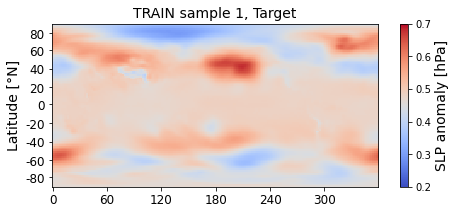

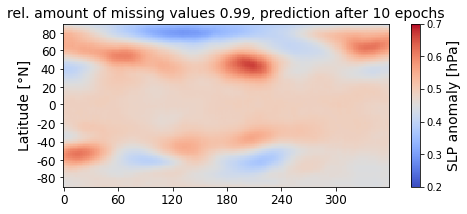

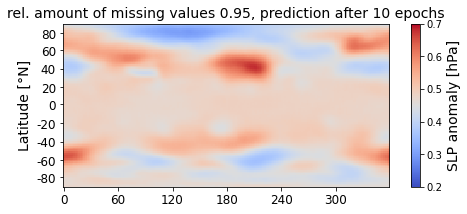

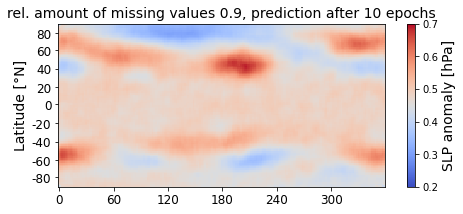

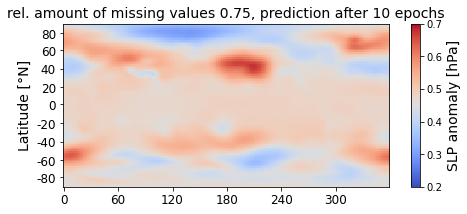

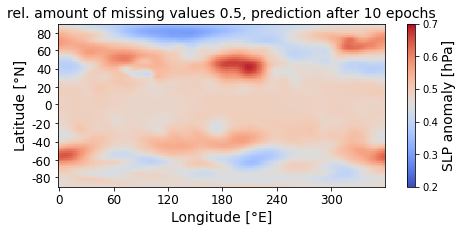

In [42]:
## Plot target from TRAINING data:

fig, ax = plt.subplots(figsize=(8, 3))

im = plt.imshow(train_target_all[k], cmap="coolwarm", interpolation='nearest', vmin=0.2, vmax=0.7)
cbar = plt.colorbar(im)
cbar.set_label("SLP anomaly [hPa]", fontsize=14)

plt.title('TRAIN sample '+str(k+1)+', Target', fontsize=14)
#plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 192, step=32), [0, 60, 120, 180, 240, 300], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)

plt.show()

## Plot corresponding model prediction:

# Loop over rel. amount of missing valuess:
for i in range(len(missing_values)):

    fig, ax = plt.subplots(figsize=(8, 3))

    im = plt.imshow(train_pred_all[i,j,k,:,:], cmap="coolwarm", interpolation='nearest', vmin=0.2, vmax=0.7)
    cbar = plt.colorbar(im)
    cbar.set_label("SLP anomaly [hPa]", fontsize=14)

    plt.title('rel. amount of missing values '+str(missing_values[i])+', prediction after '+str(j)+' epochs', fontsize=14)
    if i == len(missing_values)-1:
        plt.xlabel('Longitude [°E]', fontsize=14)
    plt.ylabel('Latitude [°N]', fontsize=14)
    plt.xticks(np.arange(0, 192, step=32), [0, 60, 120, 180, 240, 300], fontsize=12)
    plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)

    plt.show()

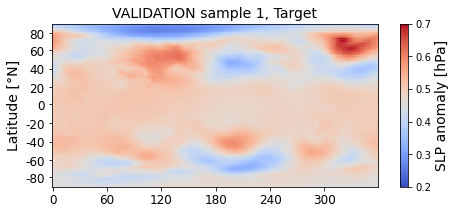

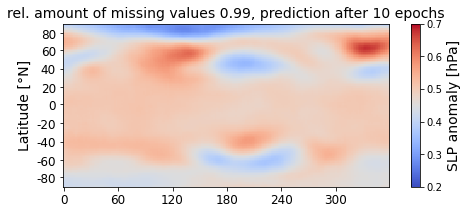

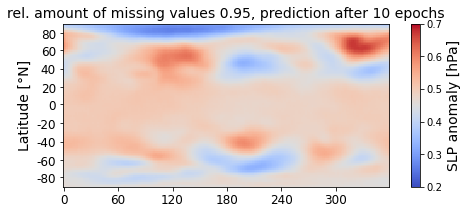

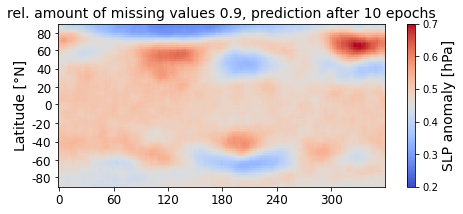

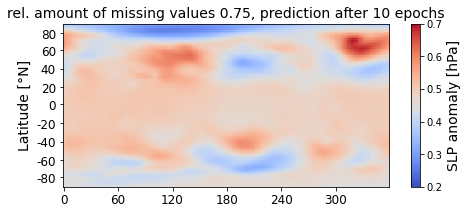

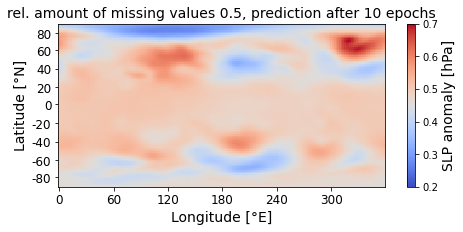

In [43]:
## Plot target from VALIDATION data:

fig, ax = plt.subplots(figsize=(8, 3))

im = plt.imshow(val_target_all[k], cmap="coolwarm", interpolation='nearest', vmin=0.2, vmax=0.7)
cbar = plt.colorbar(im)
cbar.set_label("SLP anomaly [hPa]", fontsize=14)

plt.title('VALIDATION sample '+str(k+1)+', Target', fontsize=14)
#plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 192, step=32), [0, 60, 120, 180, 240, 300], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)

plt.show()

## Plot corresponding model prediction:

# Loop over rel. amount of missing values:
for i in range(len(missing_values)):

    fig, ax = plt.subplots(figsize=(8, 3))

    im = plt.imshow(val_pred_all[i,j,k,:,:], cmap="coolwarm", interpolation='nearest', vmin=0.2, vmax=0.7)
    cbar = plt.colorbar(im)
    cbar.set_label("SLP anomaly [hPa]", fontsize=14)

    plt.title('rel. amount of missing values '+str(missing_values[i])+', prediction after '+str(j)+' epochs', fontsize=14)
    if i == len(missing_values)-1:
        plt.xlabel('Longitude [°E]', fontsize=14)
    plt.ylabel('Latitude [°N]', fontsize=14)
    plt.xticks(np.arange(0, 192, step=32), [0, 60, 120, 180, 240, 300], fontsize=12)
    plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)

    plt.show()